In [1]:
#********************************************
# Helper functions for pairwise features
#********************************************

def get_pairwise_header(text_list):
    new_headers = []
    # get a list of strings
    for f1 in text_list:
        for f2 in text_list:
            if f1 == f2:
                continue
            new_f = f1+'+'+f2
            new_headers.append(new_f)
    return new_headers
x = ['a','b','c']
print(get_pairwise_header(x))
    
def get_pairwise_record(vals):
    new_vals = []
    # get a list of strings
    num_vals = len(vals)
    for i in range(num_vals):
        for j in range(num_vals):
            if i == j:
                continue
            f1 = int(vals[i])
            f2 = int(vals[j])
            new_f = f1*f2
            new_vals.append(new_f)
    return new_vals
x = [3,4,5]
print(get_pairwise_record(x))
    

['a+b', 'a+c', 'b+a', 'b+c', 'c+a', 'c+b']
[12, 15, 12, 20, 15, 20]


In [2]:
#********************************************
# Load in the data
#********************************************

import numpy as np
x_train = []
y_train = []
x_dev = []
y_dev = []
import random
cnt = 0
is_pairwise = False
is_include_opioid_abuse = True  # as part of the label

def _get_label(vals):
    if is_include_opioid_abuse:
        l1 = int(vals[1])
        l2 = int(vals[opioid_abuse_idx])
        label = l1 or l2
    else:
        label = vals[1]
    return label
    

with open('Complete_Feature_Extract_new.csv','r') as f:
    for line in f:
        cnt += 1
        if is_pairwise and cnt % 1000 == 0:
            print("On: ",cnt)
        vals = line.strip().split(',')
        assert not (is_pairwise and is_include_opioid_abuse)
        if cnt == 1:
            print(line)
            if is_pairwise:
                features = get_pairwise_header(vals[2:])
            else:
                opioid_abuse_idx = vals.index('opioid_abuse')
                if is_include_opioid_abuse:
                    features = vals[2:opioid_abuse_idx]+vals[opioid_abuse_idx+1:]
                else:
                    features = vals[2:]
            continue
        _uuid = vals[0]
        label = _get_label(vals)
        if is_pairwise:
            record_vals = get_pairwise_record(vals[2:])
        else:
            if is_include_opioid_abuse:
                record_vals = vals[2:opioid_abuse_idx]+vals[opioid_abuse_idx+1:]
            else:
                record_vals = vals[2:]
        if random.random() < .02:
            y_dev.append(label)
            x_dev.append(record_vals)
        else:
            #if int(vals[1]) == 0 and random.random() < .95:
            #    continue
            y_train.append(label)
            x_train.append(record_vals)
                
    #print(y_train)
    #print(x_train)

x_train = np.array(x_train,dtype=np.float32)
y_train = np.array(y_train,dtype=np.int)
x_dev = np.array(x_dev,dtype=np.float32)
y_dev = np.array(y_dev,dtype=np.int)
print("now in memory")
print("Num features: ",x_train.shape[1])
print("Train, Num x records: {}, Num labels: {}, Num pos: {}".format(x_train.shape[0],
                                                        y_train.shape[0],
                                                       sum(y_train)))
print("Test, Num x records: {}, Num labels: {}, Num pos: {}".format(x_dev.shape[0],
                                                       y_dev.shape[0],
                                                      sum(y_dev)))
      
print(y_train.shape)
        

"ucm_enrolled_recipient_id_uuid",od_flag,age_lt_30,age_31_to_50,age_51_to_65,age_gt_66,coagulopathy,hypertension,hypothyroidism,lymphoma,metastic_cancer,obesity,osteoporosis,"other_neurological_disorder",paralysis,"peptic_ulcer_disease_excl_bleeding","peripheral_vascular_disorder","pulmonary_circulation_disorder",rhenal_failure,ra_collagen_vascular,sleep_apnea,"solid_tumor_wo_metastasis",valvular_disease,weight_loss,liver_disease,aids,blood_loss_anemia,cardiac_arrhythmia,copd,electrolyte_disorders,diabetes_uncomplicated,diabetes_complicated,deficiency_anemia,congestive_heart_failure,bipolar_disorder,other_mh_disorder,"major_depressive_disorder",detox_flag,"od_suicide_attempt_2014_flag",er_visit_flag,ip_mh_treatment_flag,other_drug_class0,other_drug_class1,other_drug_class2,other_drug_class3,"other_substance_use_disorder",sedative_use_disorder,alcohol_abuse,stimulant_use_disorder,tobacco_abuse,opioid_abuse,"cannabis_hallucinogen_use_disorder",copresc_sed_flag,op_tier1,op_tier2,op_tier3,

In [3]:
#********************************************
# Learn the model
#********************************************

# now learn a model
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)

# show feature importance
weights = lr.coef_.ravel()
#print("weights: ",weights)


#********************************************
# Show features
#********************************************
assert weights.shape[0] == len(features), "{}, {}".format(weights.shape[0],
                                                        len(features))

weight_dict = {}
for i,f in enumerate(features):
    f = f.replace('"','')
    weight_dict[f] = weights[i]
    print("{:<40}:{: .2f}".format(f,weights[i]))


# Save json
import json
with open('learned_weights.json', 'w') as fp:
    json.dump(weight_dict, fp)


print()
params = lr.get_params()
print("params: ",params)

score = lr.score(x_train,y_train)
print("Acurracy: {}".format(score))

score = lr.score(x_dev,y_dev)
print("Acurracy: {}".format(score))

import sklearn.metrics
y_dev_pred_lr = lr.predict(x_dev)
f1_lr = sklearn.metrics.f1_score(y_dev, y_dev_pred_lr)
print("f1 score: {:.2f}".format(f1_lr))

age_lt_30                               :-0.23
age_31_to_50                            : 0.03
age_51_to_65                            :-0.25
age_gt_66                               :-0.65
coagulopathy                            :-0.07
hypertension                            :-0.25
hypothyroidism                          :-0.19
lymphoma                                : 0.01
metastic_cancer                         :-0.43
obesity                                 :-0.33
osteoporosis                            :-0.14
other_neurological_disorder             :-0.11
paralysis                               :-0.38
peptic_ulcer_disease_excl_bleeding      : 0.14
peripheral_vascular_disorder            :-0.10
pulmonary_circulation_disorder          : 0.13
rhenal_failure                          :-0.15
ra_collagen_vascular                    :-0.06
sleep_apnea                             :-0.27
solid_tumor_wo_metastasis               :-0.22
valvular_disease                        :-0.05
weight_loss  

In [4]:
#********************************************
# Show sample outputs
#********************************************
pred_prob_y = lr.predict_proba(x_dev)
for i in range(len(x_dev)):
    if random.random() > 0.95 or y_dev[i]:
        print("{}:{:.2f}".format(y_dev[i],pred_prob_y[i][1]))
    if i > 1000:
        break


1:0.64
1:0.02
1:0.85
1:0.36
0:0.02
0:0.00
1:0.52
0:0.01
0:0.13
1:0.13
0:0.74
1:0.12
1:0.07
1:0.27
1:0.86
1:0.38
1:0.11
1:0.17
1:0.76
1:0.90
1:0.38
1:0.87
1:0.78
0:0.08
0:0.12
1:0.87
1:0.53
1:0.32
1:0.14
1:0.67
1:0.33
1:0.64
1:0.80
1:0.74
1:0.66
0:0.09
1:0.94
1:0.01
0:0.11
0:0.01
1:0.38
1:0.73
0:0.01
1:0.02
0:0.01
1:0.36
1:0.74
0:0.24
1:0.31
1:0.99
1:0.86
0:0.01
1:0.37
1:0.07
0:0.07
0:0.04
1:0.31
0:0.03
1:0.53
1:0.33
0:0.30
0:0.06
1:0.87
1:0.82
1:0.50
1:0.29
1:0.49
1:0.24
1:0.19
0:0.01
1:0.32
1:0.08
0:0.04
1:0.97
1:0.19
1:0.07
0:0.01
0:0.00
1:0.63
1:0.10
1:0.10
1:0.08
1:0.73
1:0.15
1:0.29
1:0.87
0:0.10
0:0.06
1:0.01
0:0.01
1:0.52
1:0.47
1:0.56
1:0.29
1:0.27
1:0.11
1:0.72
1:0.93
0:0.01
0:0.11
0:0.11
1:0.44
0:0.02
0:0.01
1:0.84
0:0.00
0:0.00
1:0.99
1:0.42
1:0.23
1:0.33
1:0.81
1:0.27
1:0.07
0:0.38
1:0.54
1:0.95
0:0.01
1:0.09
1:0.80
1:0.04
1:0.11
1:0.02
0:0.01
1:0.80
1:0.89
1:0.02
1:0.00
0:0.01
0:0.22
1:0.31
1:0.92


In [5]:
#********************************************
# Average precision
#********************************************

y_score = lr.decision_function(x_dev)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_dev, y_score)
print("Precision: ",average_precision)

#from sklearn.metrics import precision_recall_fscore_support
#p,r,f,s = precision_recall_fscore_support(y_dev, y_score)
#print(p,r,f,s)



Precision:  0.644917850632


[ 0.10233806  0.10199387  0.10203299 ...,  1.          1.          1.        ]
(1876,)
[ 1.          0.99625468  0.99625468 ...,  0.00749064  0.00374532  0.        ]
[-5.49909582 -5.49402521 -5.48038792 ...,  4.26036446  4.43072452
  5.03119808]
i: 0, thresh: -5.50, precision: 0.10, recall: 1.00
i: 100, thresh: -5.21, precision: 0.11, recall: 0.99
i: 200, thresh: -5.01, precision: 0.11, recall: 0.99
i: 300, thresh: -4.86, precision: 0.13, recall: 0.99
i: 400, thresh: -4.69, precision: 0.14, recall: 0.99
i: 500, thresh: -4.53, precision: 0.16, recall: 0.99
i: 600, thresh: -4.38, precision: 0.17, recall: 0.99
i: 700, thresh: -4.24, precision: 0.20, recall: 0.98
i: 800, thresh: -4.01, precision: 0.22, recall: 0.98
i: 900, thresh: -3.72, precision: 0.24, recall: 0.96
i: 1000, thresh: -3.15, precision: 0.27, recall: 0.93
i: 1100, thresh: -2.76, precision: 0.30, recall: 0.91
i: 1200, thresh: -2.50, precision: 0.33, recall: 0.89
i: 1300, thresh: -2.22, precision: 0.38, recall: 0.86
i: 1400, t

Text(0.5,1,'2-class Precision-Recall curve: AP=0.64')

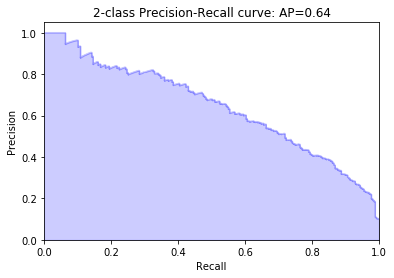

In [6]:
#********************************************
# Plot precision and recall curve
#********************************************

%matplotlib inline
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_dev, y_score)

print(precision)
print(precision.shape)
print(recall)
print(thresholds)
for i in range(0,precision.shape[0],100):
    print("i: {}, thresh: {: .2f}, precision: {:.2f}, recall: {:.2f}".format(i,
                                                                             thresholds[i],
                                                                             precision[i],
                                                                     recall[i]))

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [7]:
#********************************************
# Try random forest for comparison
#********************************************

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10)
rf = rf.fit(x_train,y_train)

score = rf.score(x_train,y_train)
print("Accuracy: {}".format(score))

score = rf.score(x_dev,y_dev)
print("Accuracy: {}".format(score))

Acurracy: 0.9794713959151963
Acurracy: 0.9172234595397178


In [8]:
import sklearn.metrics
y_dev_pred_rf = rf.predict(x_dev)
f1_rf = sklearn.metrics.f1_score(y_dev, y_dev_pred_rf)
print("f1 score: {:.2f}".format(f1_rf))

f1 score: 0.49


In [9]:
#********************************************
# SVM is too slow
#********************************************

#from sklearn import svm
#clf = svm.SVC()
#clf.fit(x_train,y_train) 

#score = clf.score(x_train,y_train)
#print("Acurracy: {}".format(score))

#score = clf.score(x_dev,y_dev)
#print("Acurracy: {}".format(score))

In [10]:
#import sklearn.metrics
#y_dev_pred_svm = clf.predict(x_dev)
#f1_svm = sklearn.metrics.f1_score(y_dev, y_dev_pred_svm)
#print("f1 score: {:.2f}".format(f1_svm))